<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband%20/Aging_CRV127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hist
!pip install mplhep
import hist

import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
pd.set_option('display.max_rows', None)

In [3]:
!apt-get -qq install krb5-user
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'

Preconfiguring packages ...
Selecting previously unselected package libisc169:amd64.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../00-libisc169_1%3a9.11.3+dfsg-1ubuntu1.17_amd64.deb ...
Unpacking libisc169:amd64 (1:9.11.3+dfsg-1ubuntu1.17) ...
Selecting previously unselected package libgeoip1:amd64.
Preparing to unpack .../01-libgeoip1_1.6.12-1_amd64.deb ...
Unpacking libgeoip1:amd64 (1.6.12-1) ...
Selecting previously unselected package libdns1100:amd64.
Preparing to unpack .../02-libdns1100_1%3a9.11.3+dfsg-1ubuntu1.17_amd64.deb ...
Unpacking libdns1100:amd64 (1:9.11.3+dfsg-1ubuntu1.17) ...
Selecting previously unselected package libisccc160:amd64.
Preparing to unpack .../03-libisccc160_1%3a9.11.3+dfsg-1ubuntu1.17_amd64.deb ...
Unpacking libisccc160:amd64 (1:9.11.3+dfsg-1ubuntu1.17) ...
Selecting previously unselected package libisccfg160:amd64.
Preparing to unpack .../04-libisccfg160_1%3a9.11.3+dfsg-1ubuntu1.17_amd64.deb ...
Unpackin

In [4]:
!kinit oksuzian@FNAL.GOV

Password for oksuzian@FNAL.GOV: 


In [6]:
#!ssh  -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov 'source /cvmfs/mu2e.opensciencegrid.org/setupmu2e-art.sh; setup mu2efiletools; mu2eDatasetFileList raw.mu2e.CRV_wideband_cosmics.crvaging-001.dat' > raw_files.txt
#!ssh  -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov 'source /cvmfs/mu2e.opensciencegrid.org/setupmu2e-art.sh; setup mu2efiletools; mu2eDatasetFileList bck.mu2e.CRV_wideband_cosmics.crvaging-001.tgz' > rec_files.txt

In [7]:
!scp  -r -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/pnfs/mu2e/tape/phy-etc/bck/mu2e/CRV_wideband_cosmics/crvaging-001 .
!cp crvaging-001/tgz/*/*/bck.mu2e.CRV_wideband_cosmics.crvaging-001.*.tgz .

In [8]:
!for f in bck.mu2e.CRV_wideband_cosmics.crvaging-001.*.tgz; do tar xf "$f"; done

In [72]:
import glob

directory = 'crvreco'
#directory = 'newreco'
df_data = pd.DataFrame([])
listing = glob.glob('*reco/*.txt')
for f in listing:
#  print(f)
  fname = f.split("/")
  runnum = fname[1].split(".")[4].split("_")[0]
#  print(runnum)
  df_data_ = pd.read_csv(f, sep="\s+", skiprows=2)
  df_data_.columns = ["feb", "chan", "PE", "PEcorr"]
  df_data_['Run'] = runnum
  df_data = df_data.append(df_data_)

In [11]:
cmd="ssh  -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov" # ssh to mu2e machine
cmd=cmd+" 'source /cvmfs/mu2e.opensciencegrid.org/setupmu2e-art.sh; setup mu2efiletools;" # setup mu2efiletools
cmd=cmd+"mu2eDatasetFileList raw.mu2e.CRV_wideband_cosmics.crvaging-001.dat | grep 000.dat | xargs head -1'" # get run and date info
 
   
output = subprocess.check_output(cmd, shell=True, universal_newlines=True).split('\n')
output = list(filter(None, output))
output = [output[start::2] for start in range(2)] # split in  2 columns

In [71]:
import re
runlist = []
for x in output[0]:
     split_results = re.split('-|\.|_',x)
#     print(split_results)
     runlist.append(split_results[11])

datelist = []
for x in output[1]:
     split_results = re.split('-|\.|_',x)
#     print(split_results)
     datelist.append(split_results[4])

In [13]:
df_run_date = pd.DataFrame()
df_run_date['Date']  = datelist
df_run_date['Run']  = runlist

In [52]:
import datetime as dt
df = pd.merge(df_run_date, df_data, on="Run")
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Run'] = df['Run'].astype(int)
df = df.query('PEcorr>0')
df['DateOrd']=df['Date'].map(dt.datetime.toordinal)

In [59]:
BAD_RUNS=[42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 67, 68, 69, 80, 83, 87, 88, 89, 91, 96, 101, 110, 115]
df = df[~df.Run.isin(BAD_RUNS)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


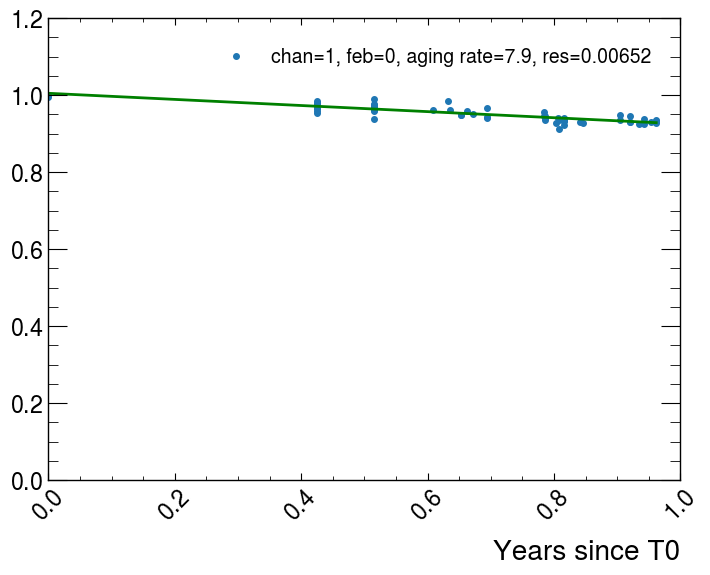

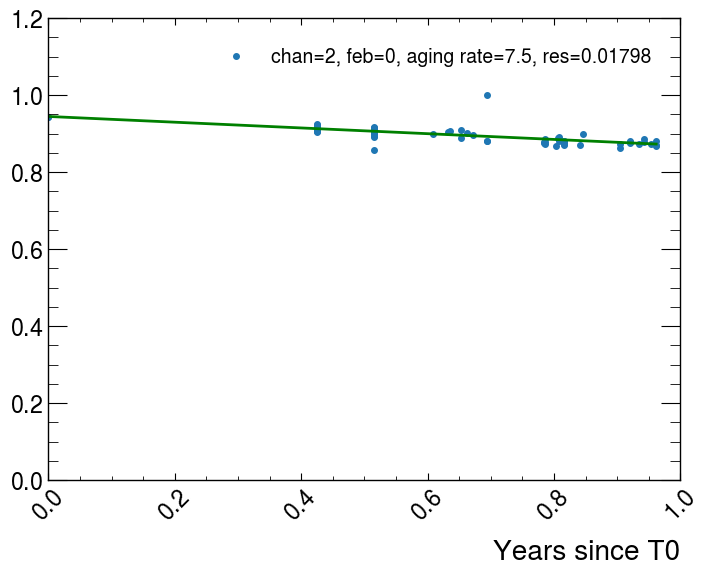

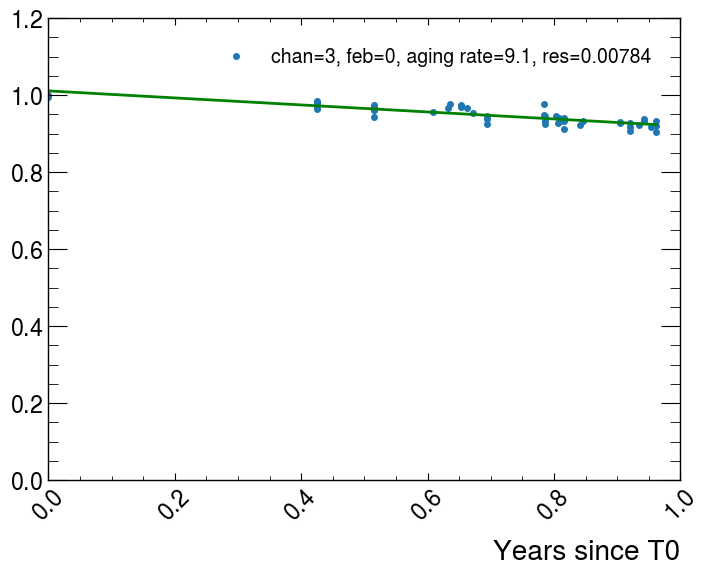

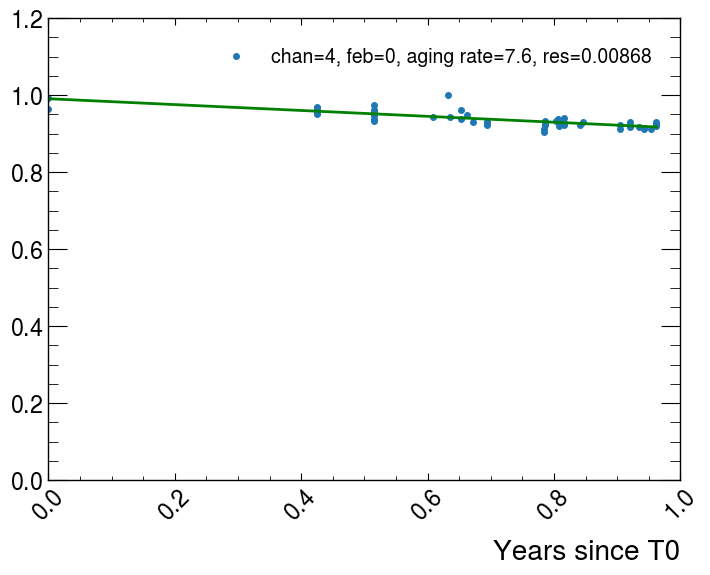

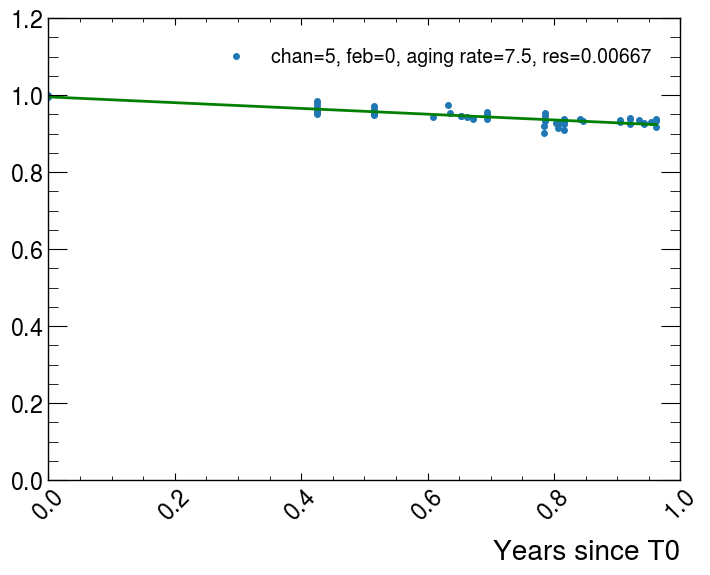

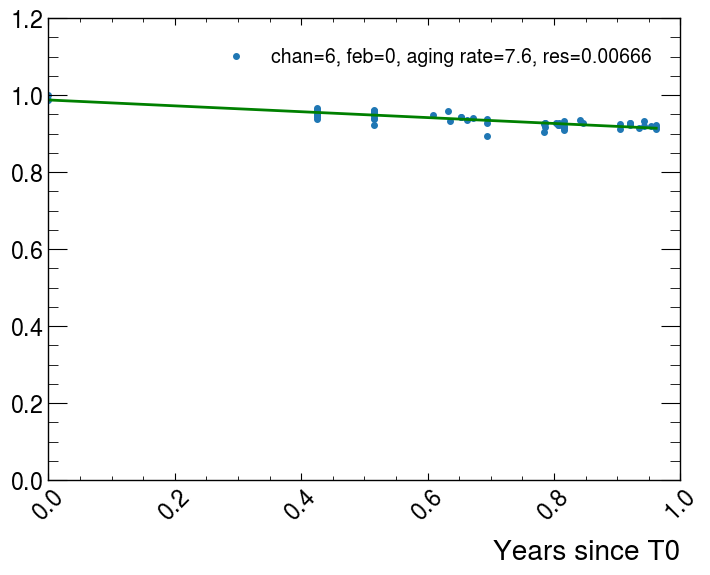

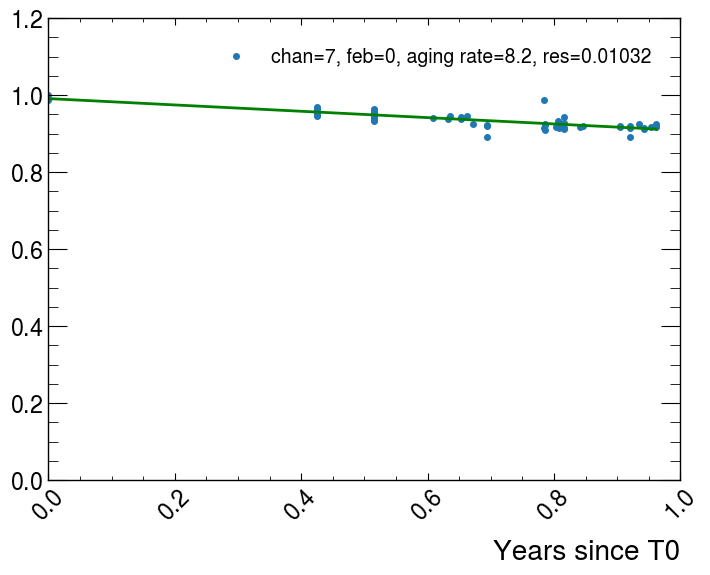

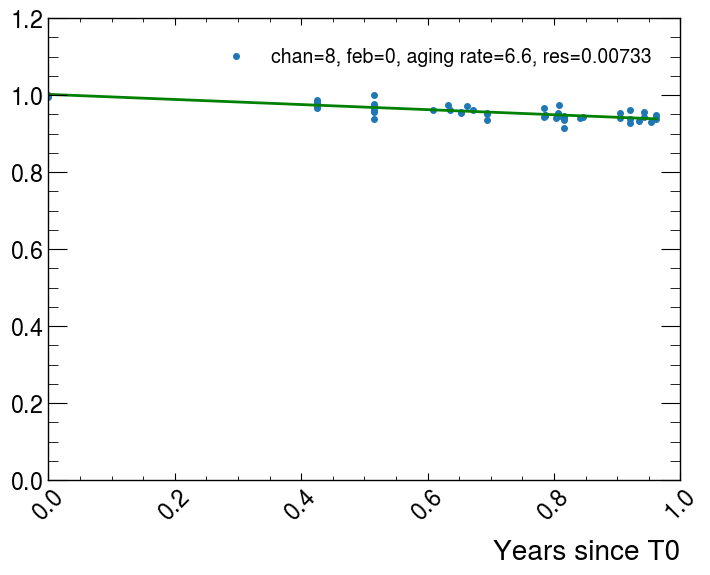

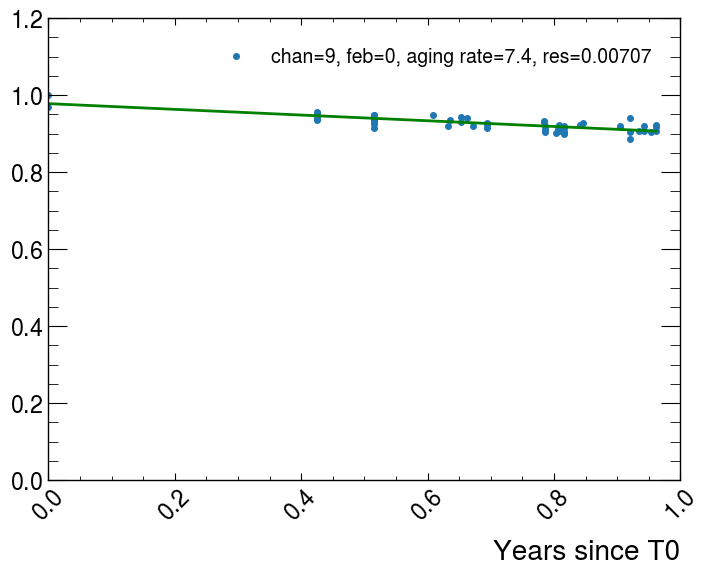

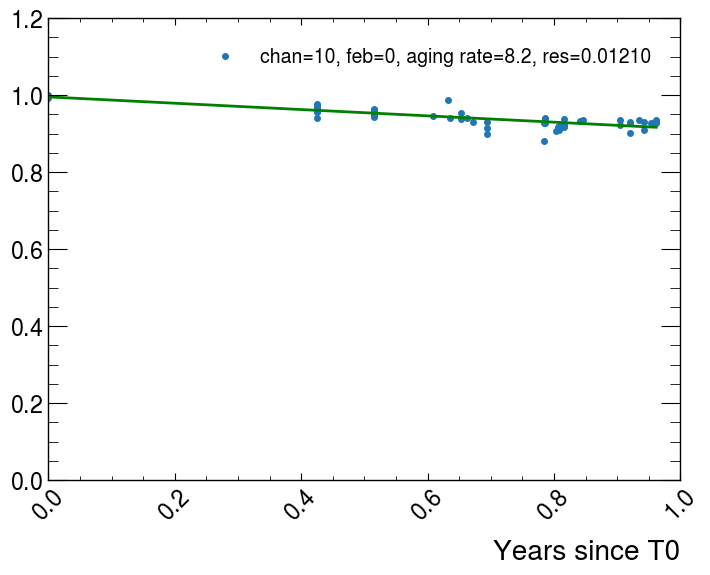

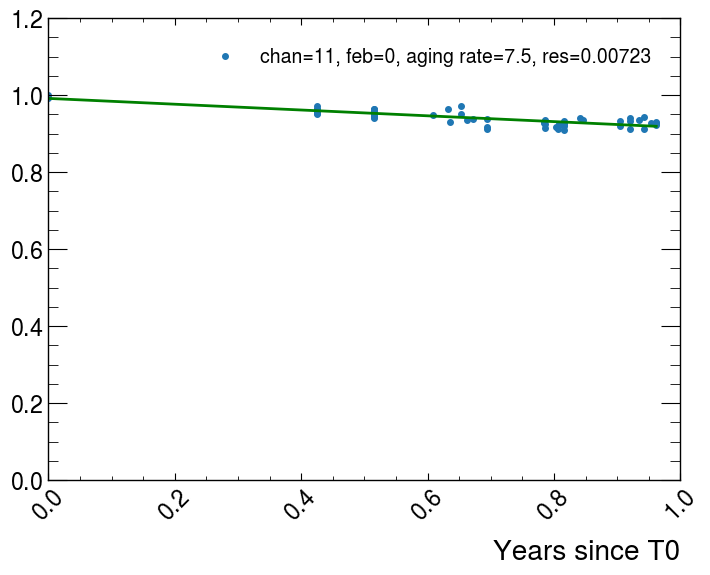

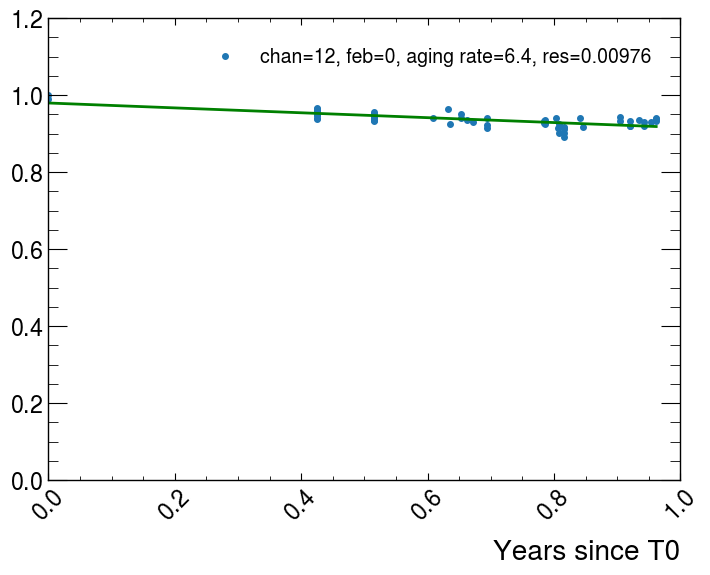

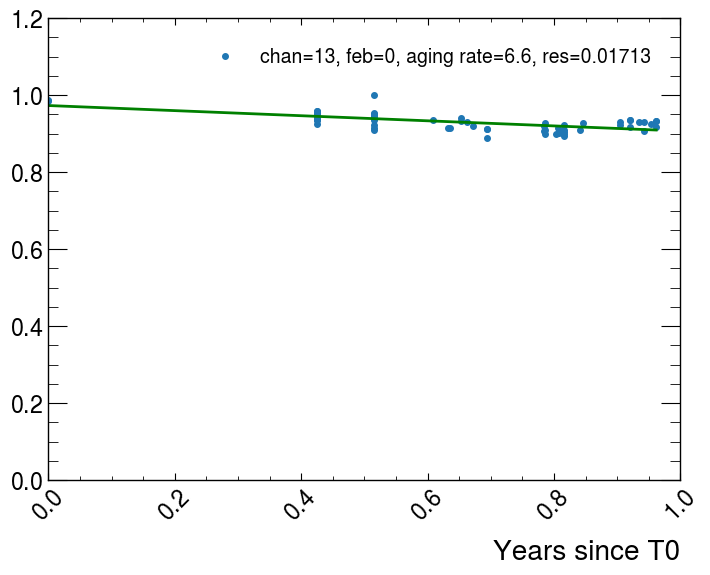

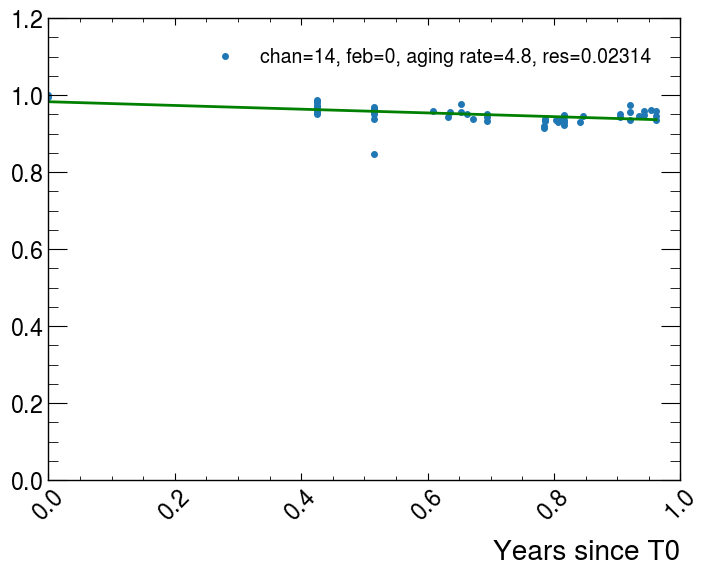

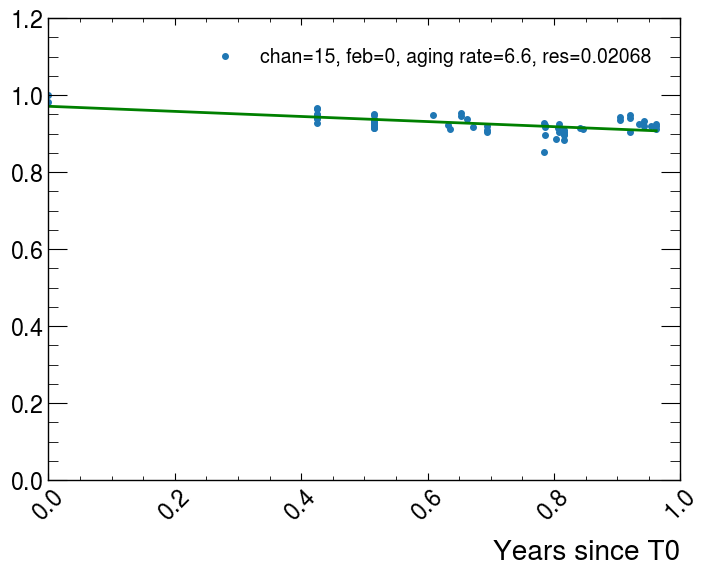

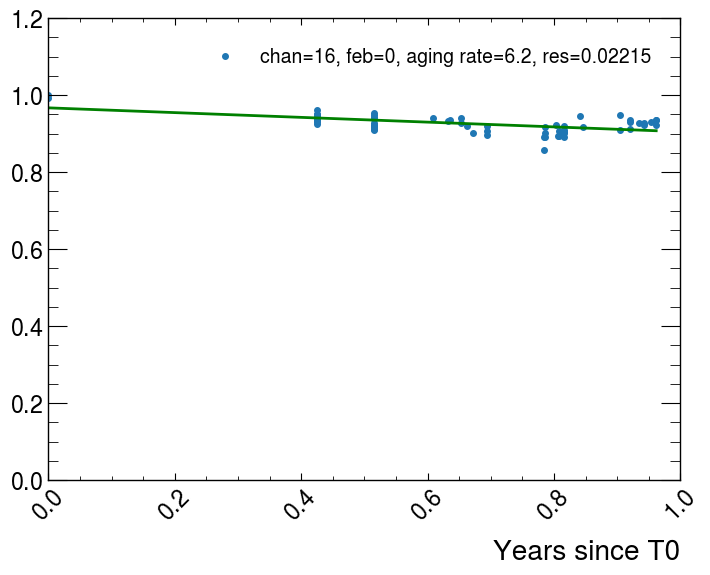

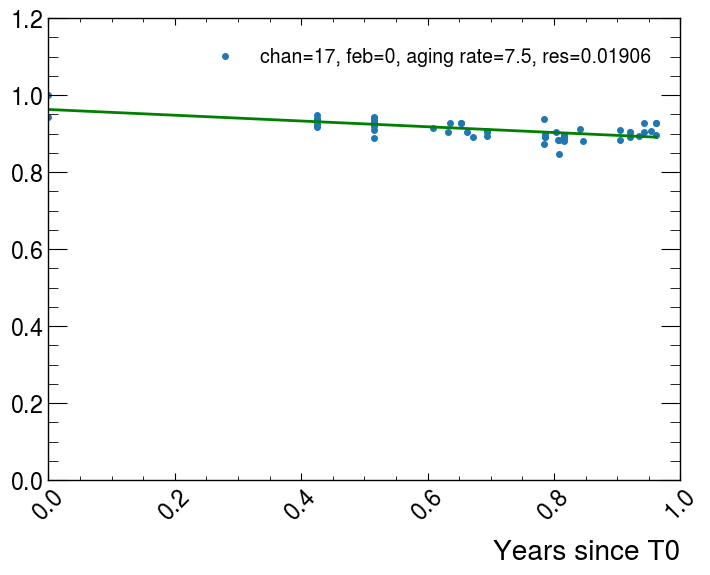

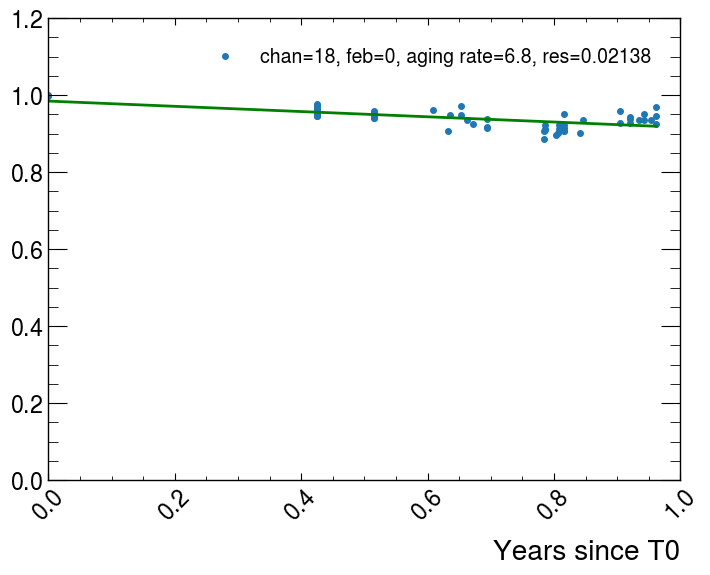

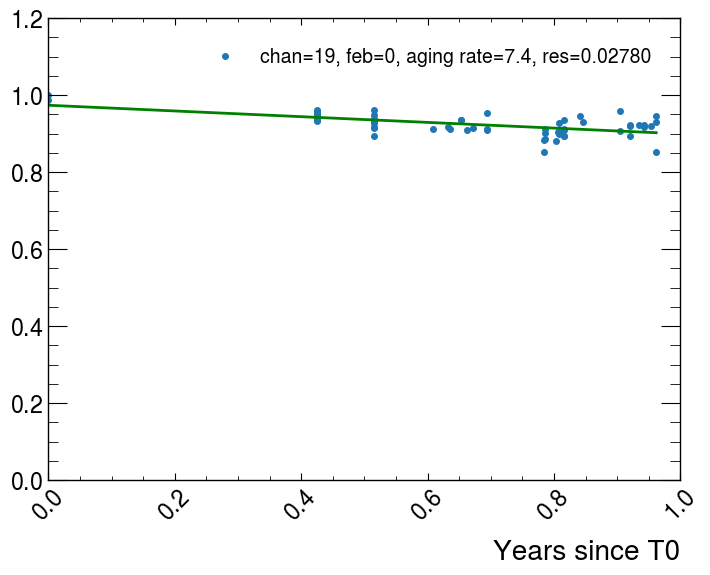

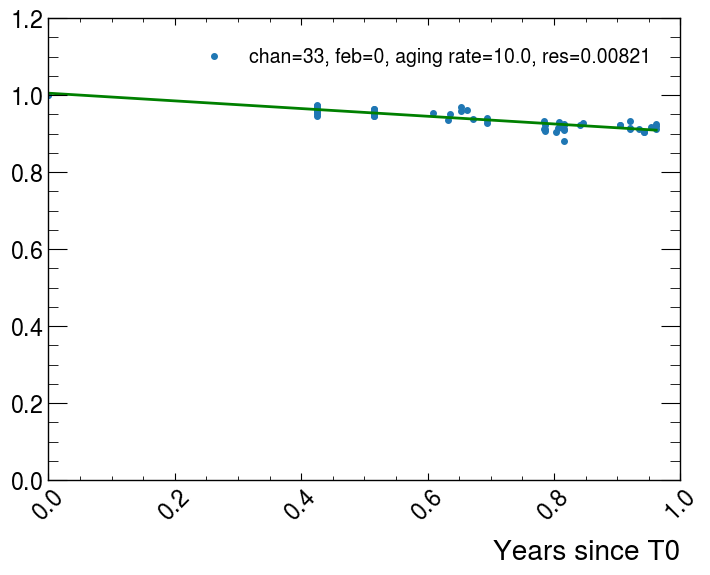

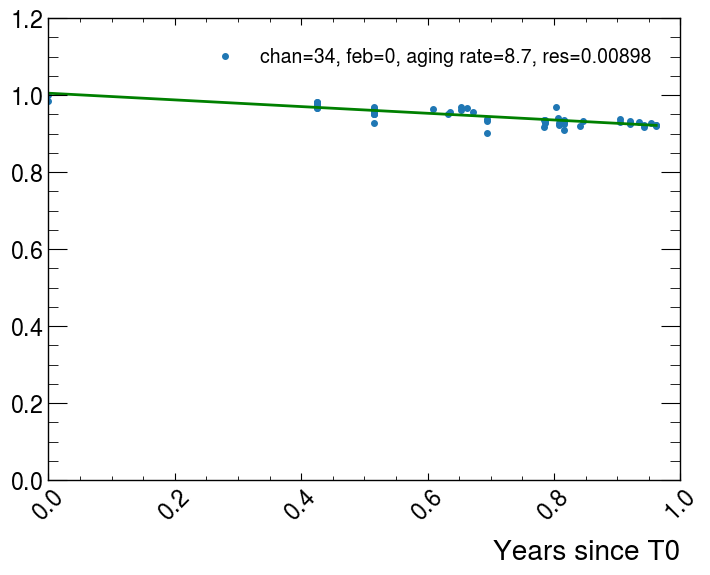

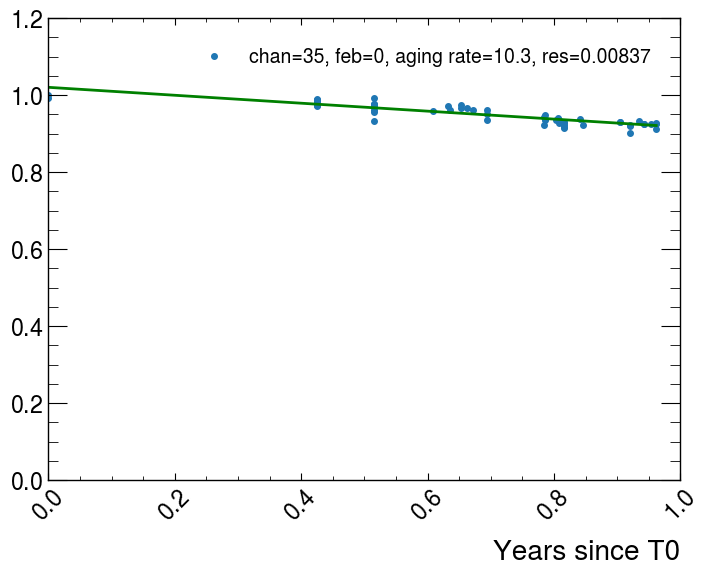

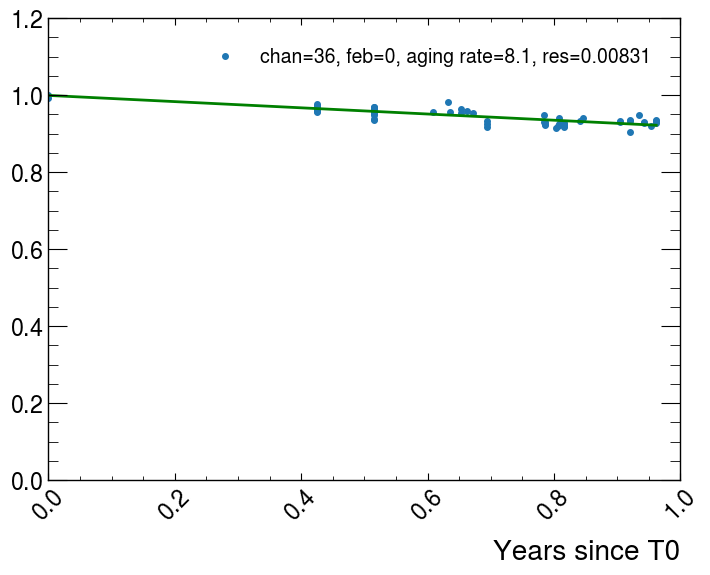

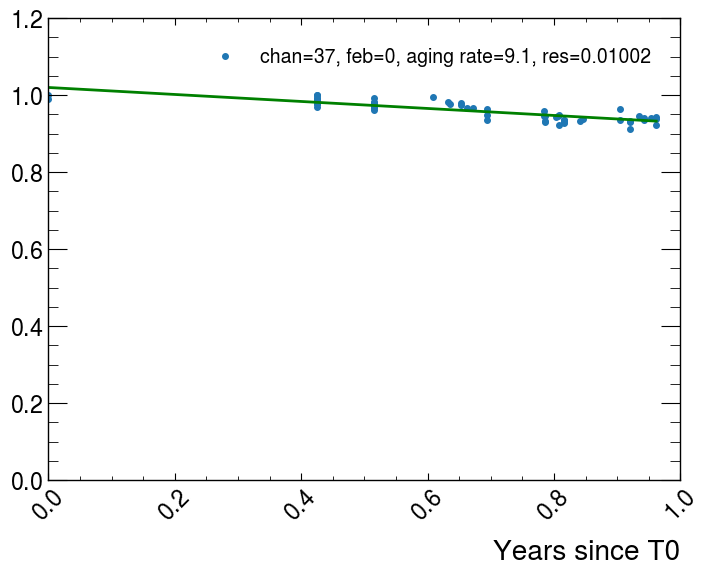

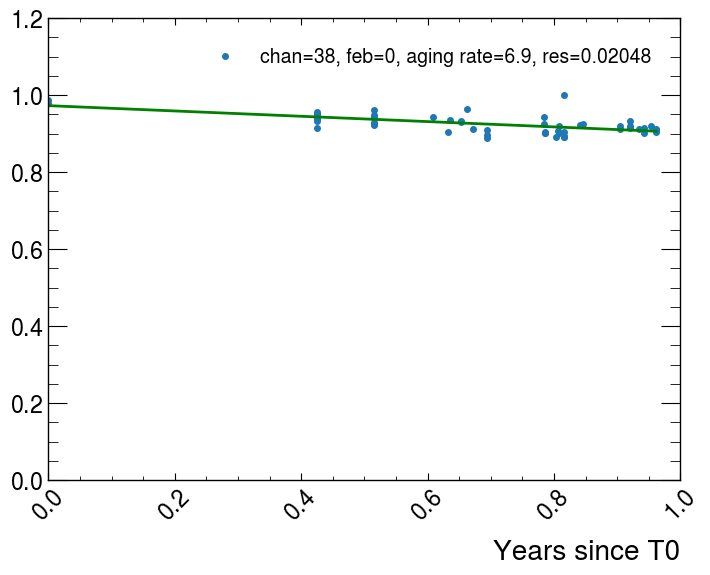

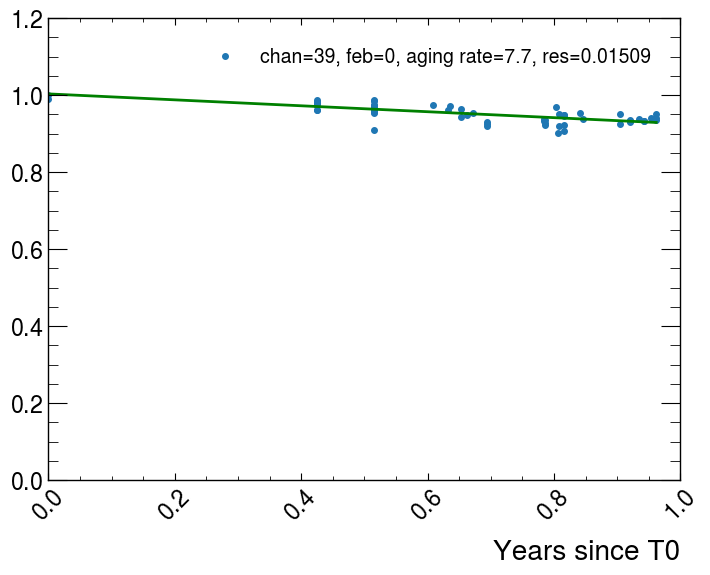

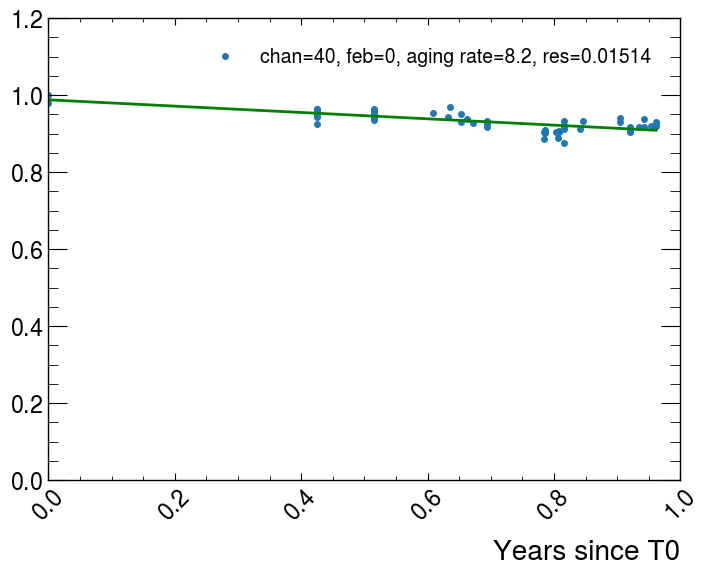

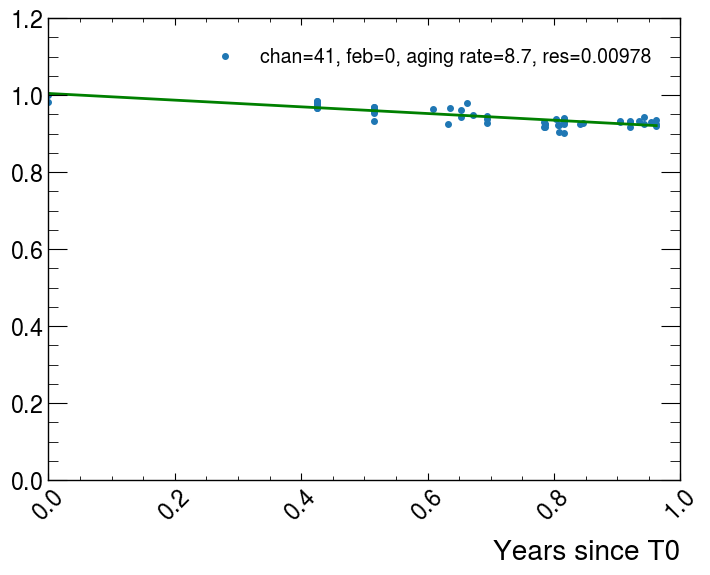

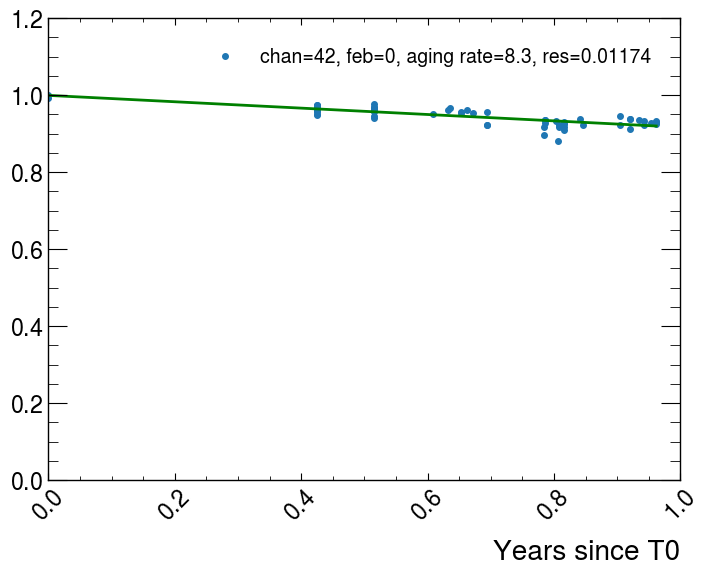

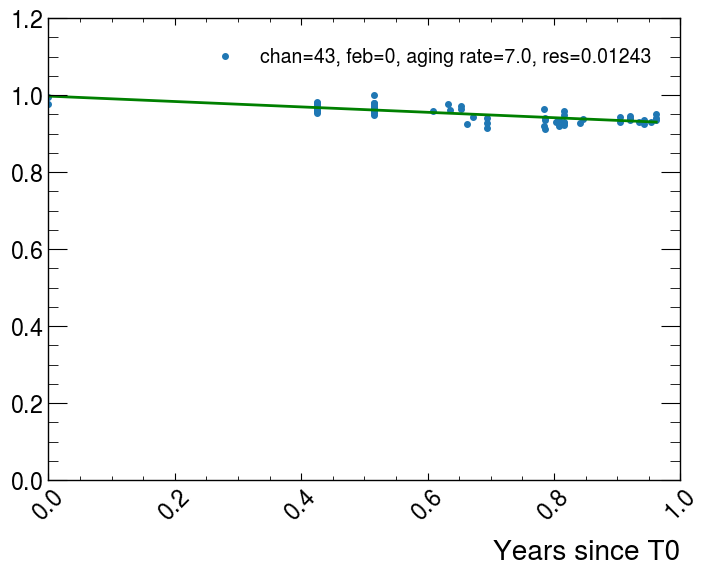

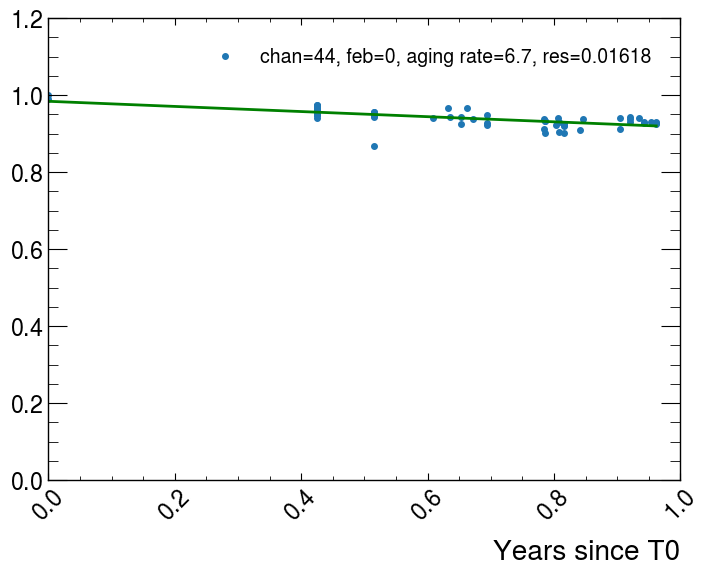

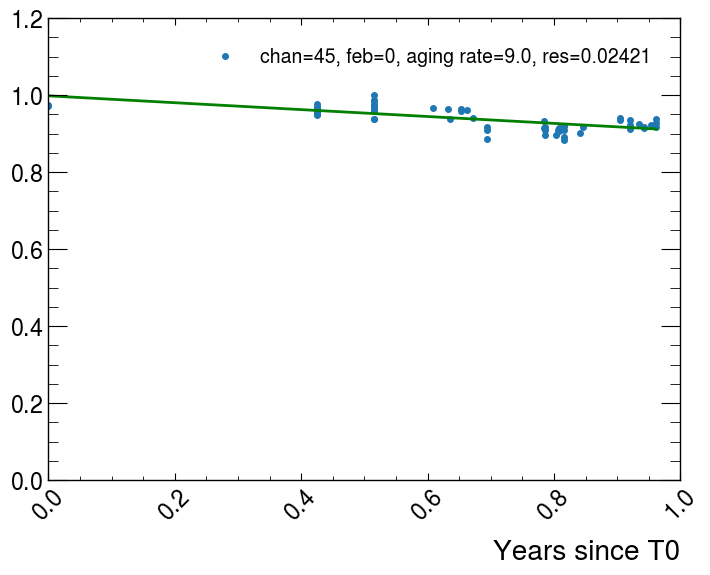

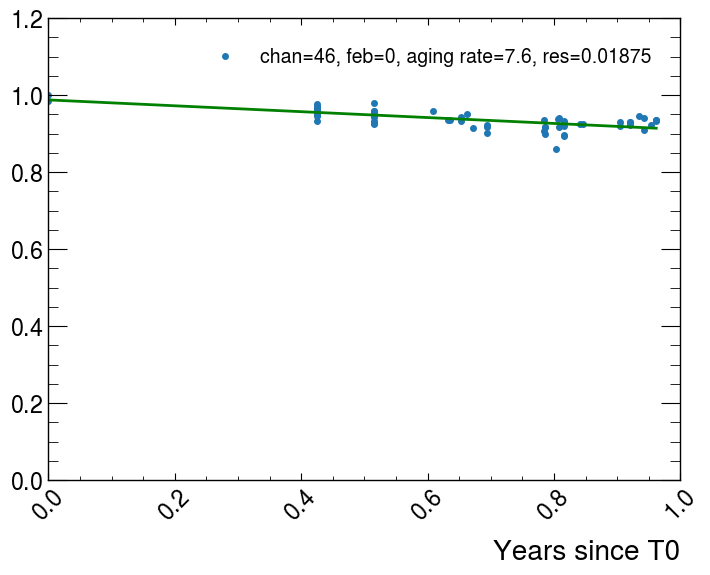

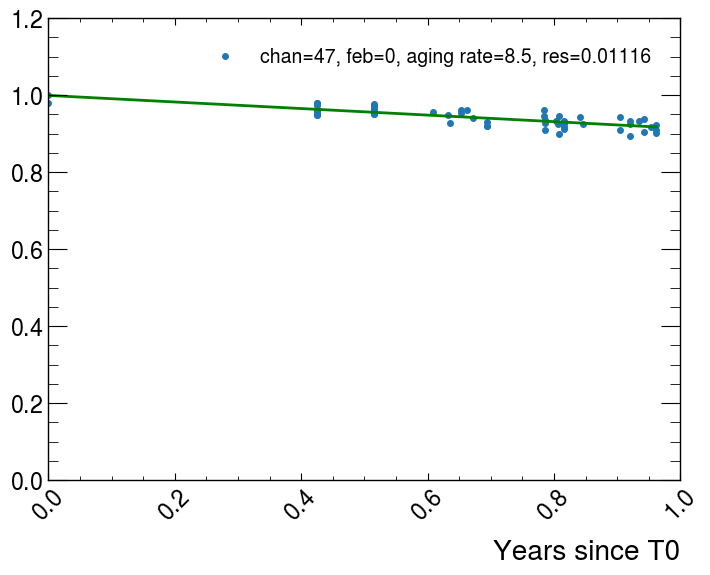

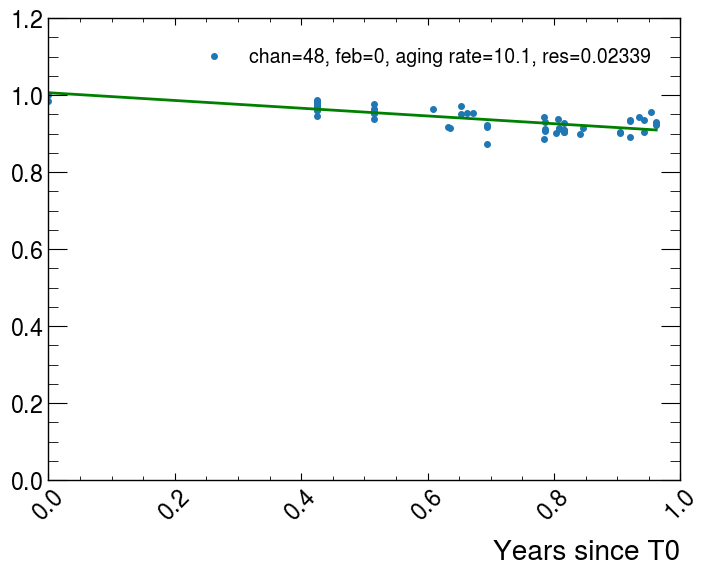

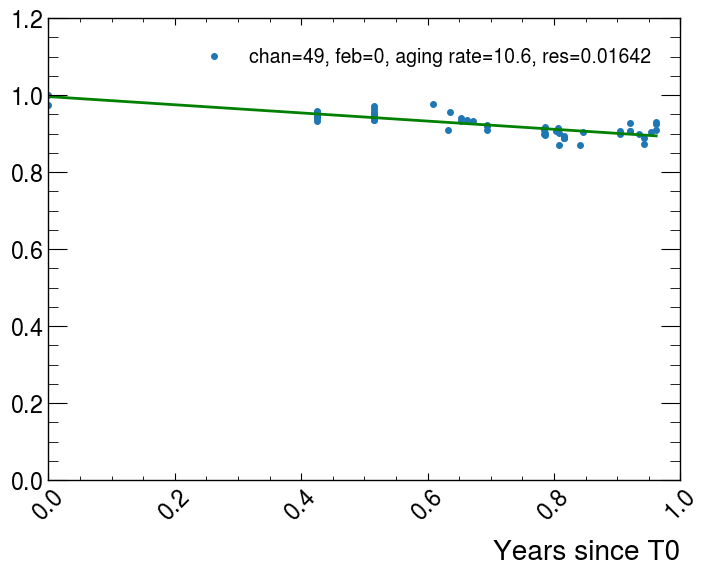

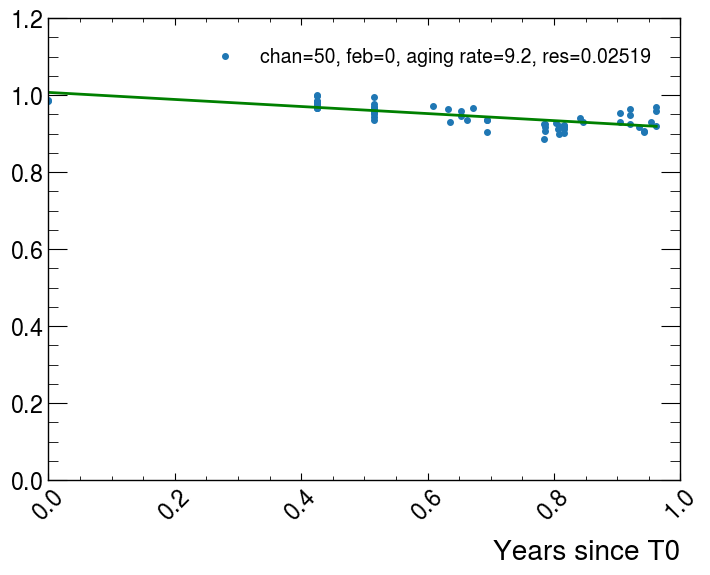

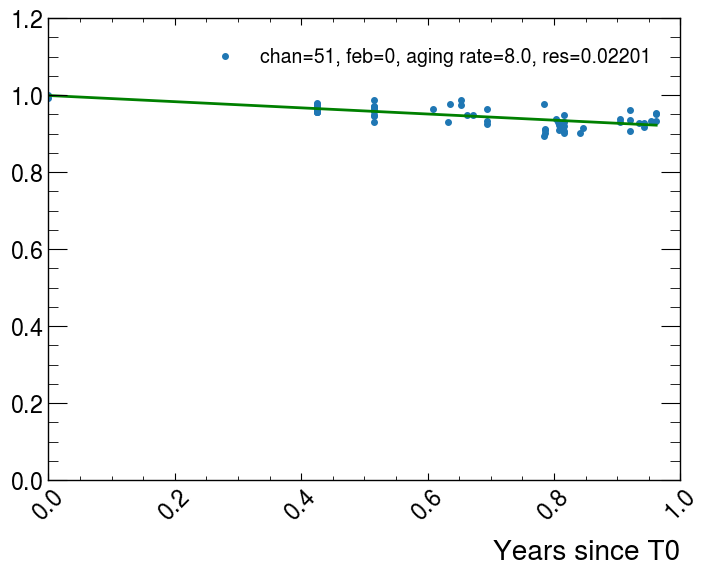

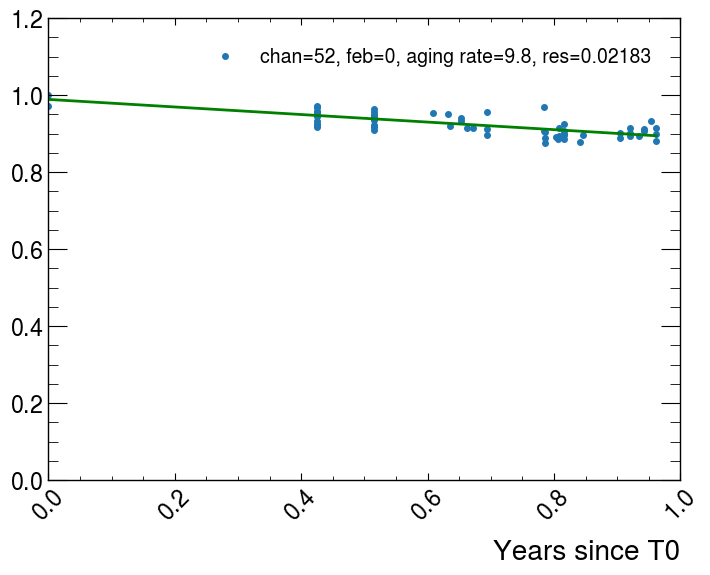

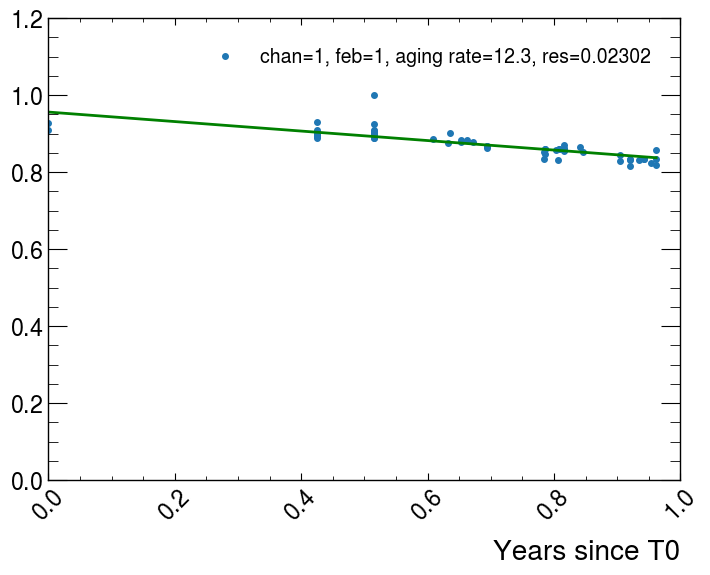

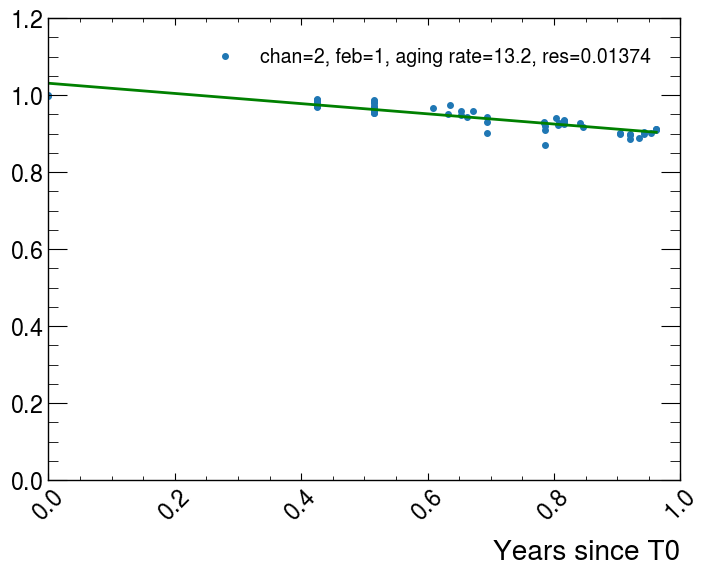

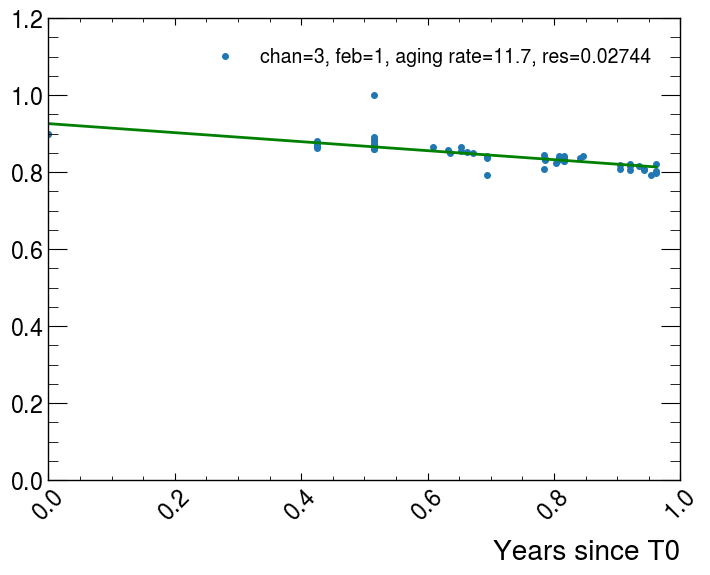

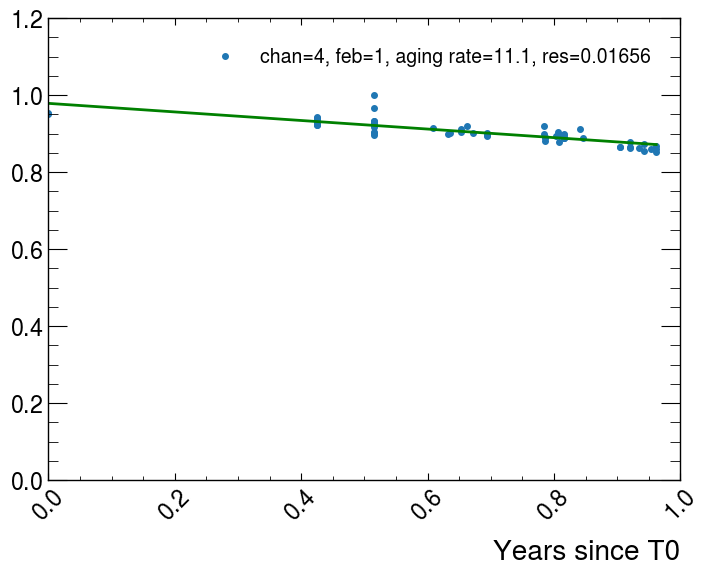

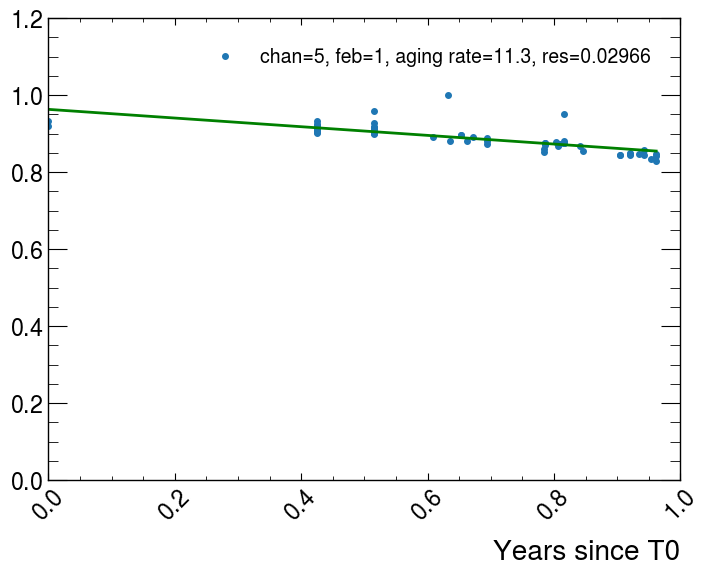

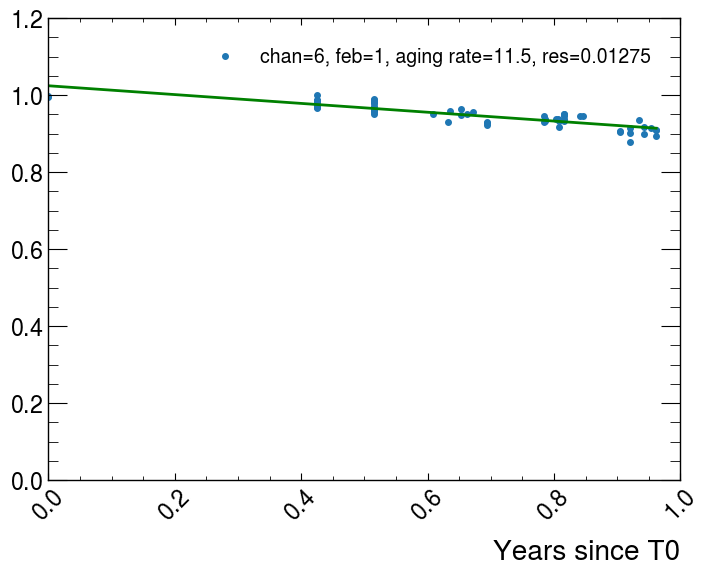

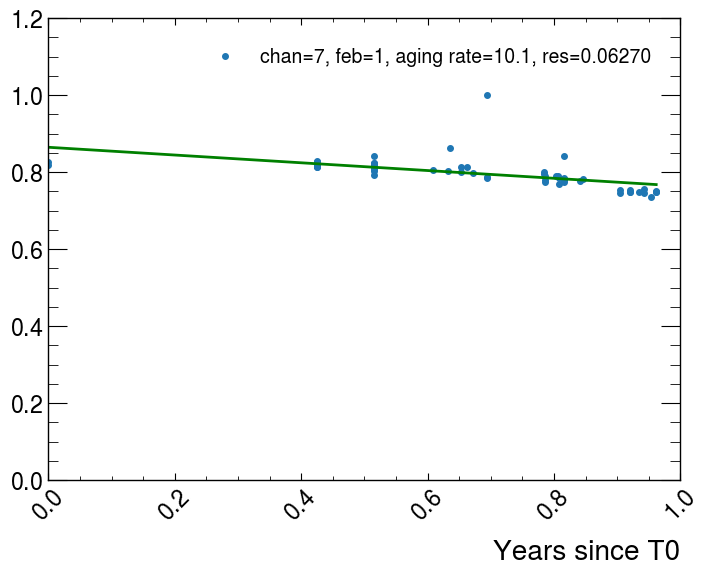

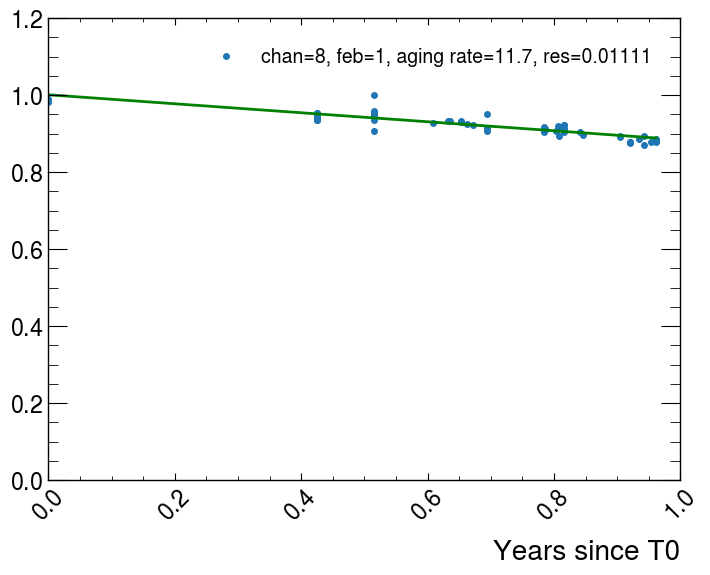

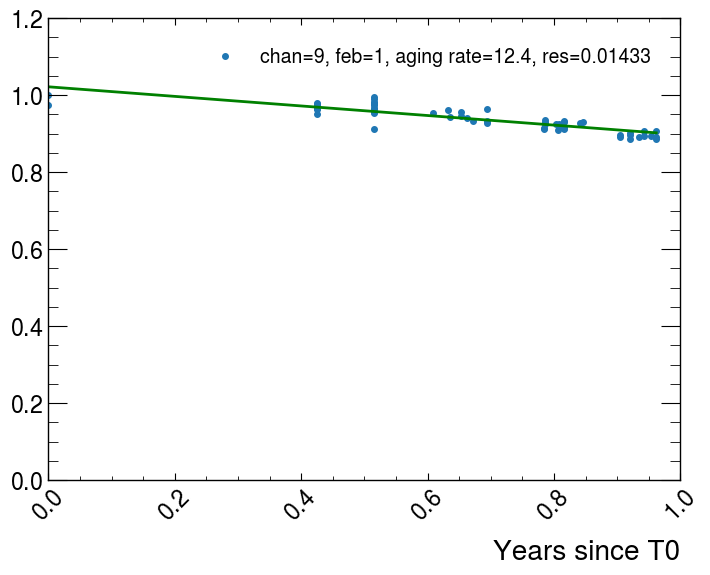

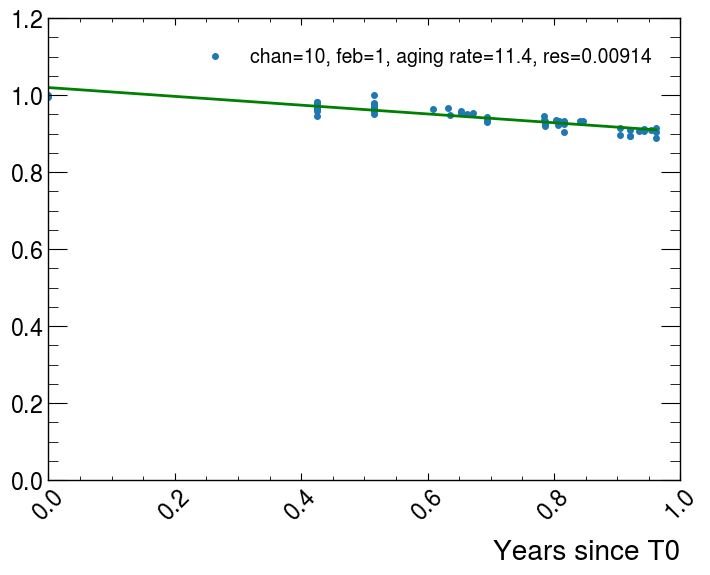

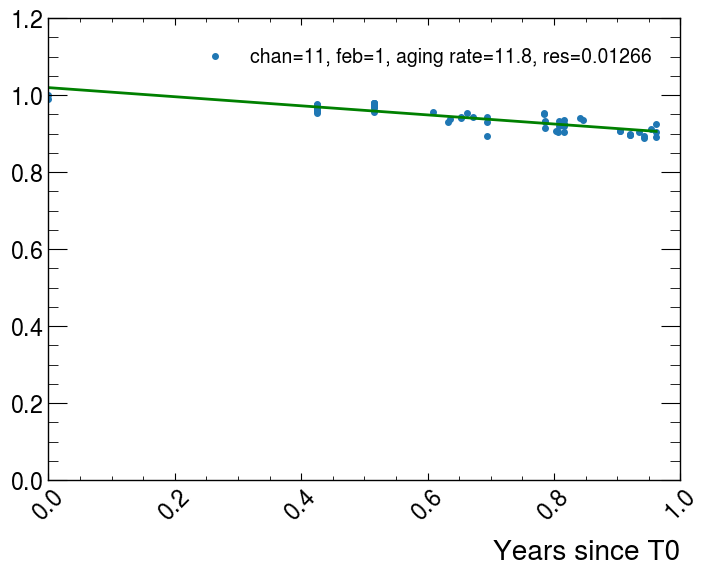

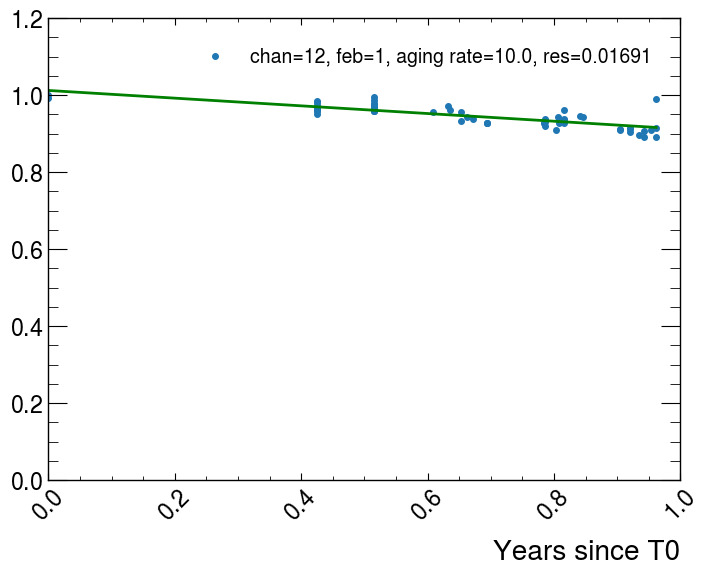

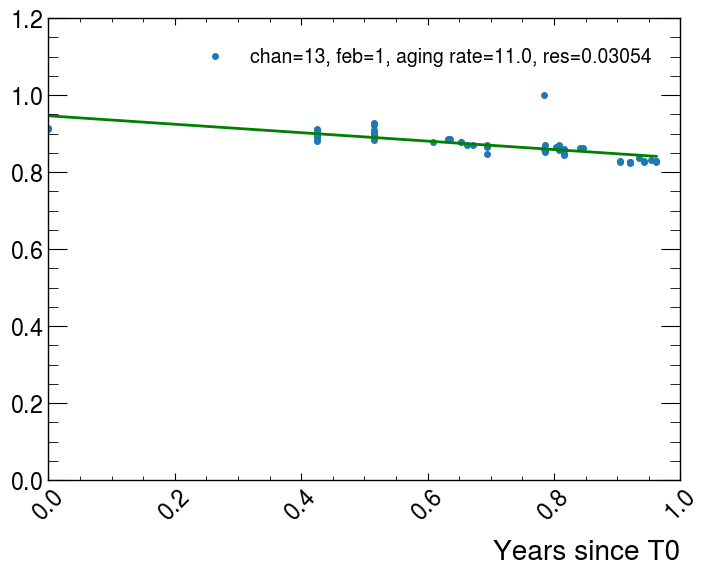

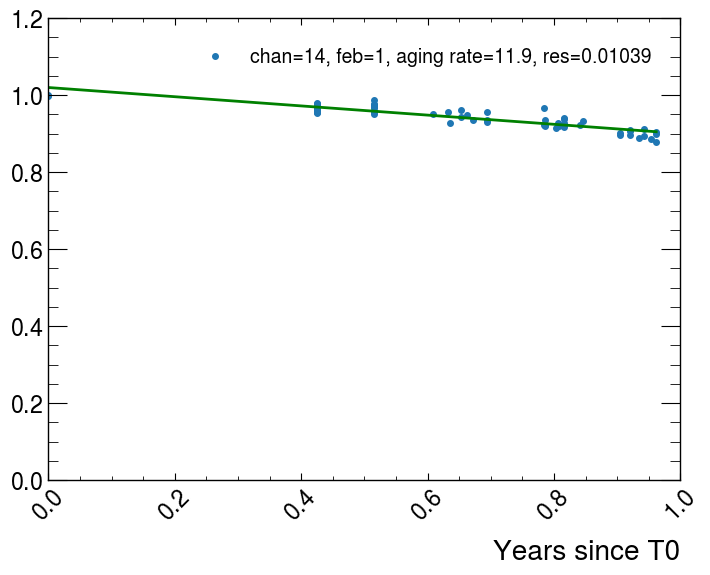

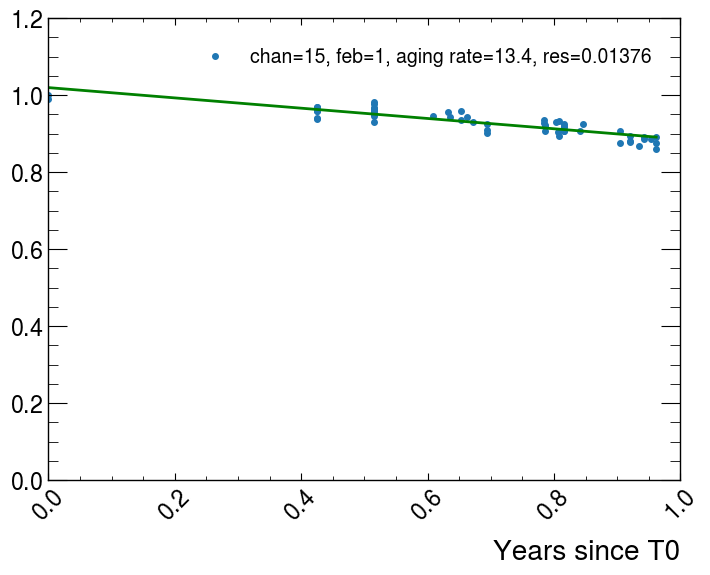

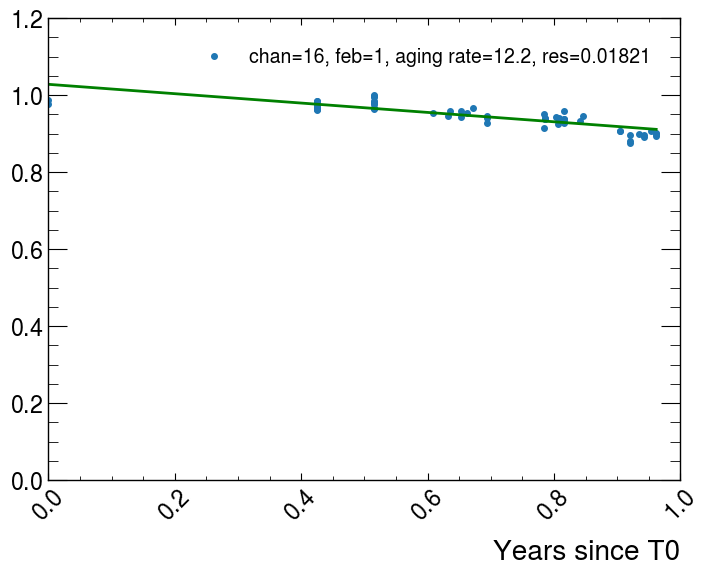

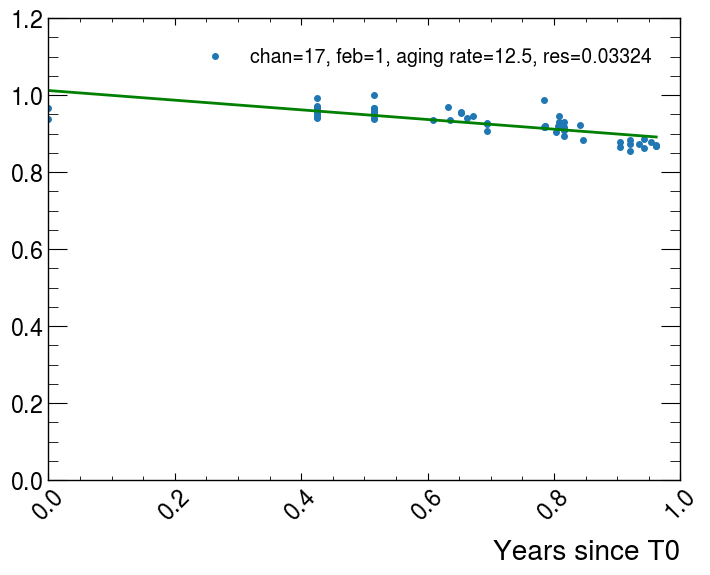

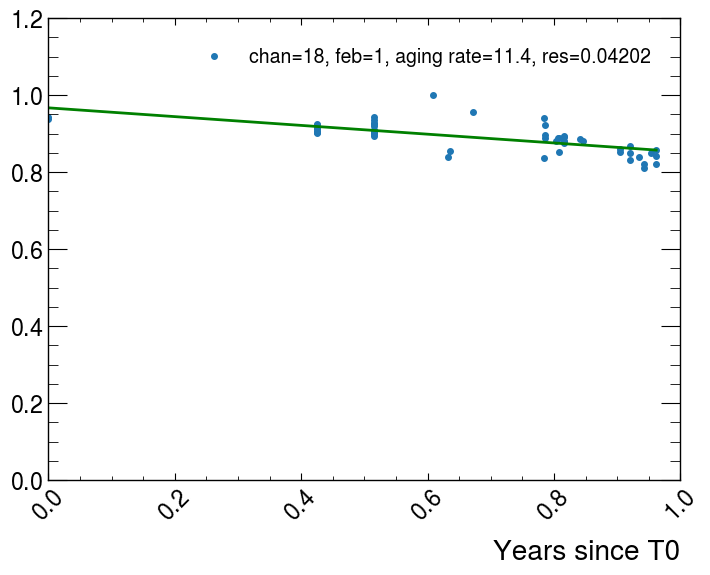

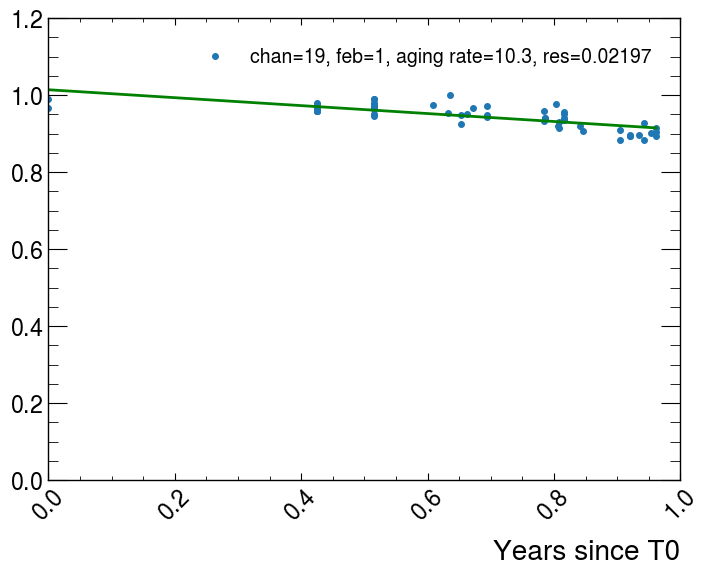

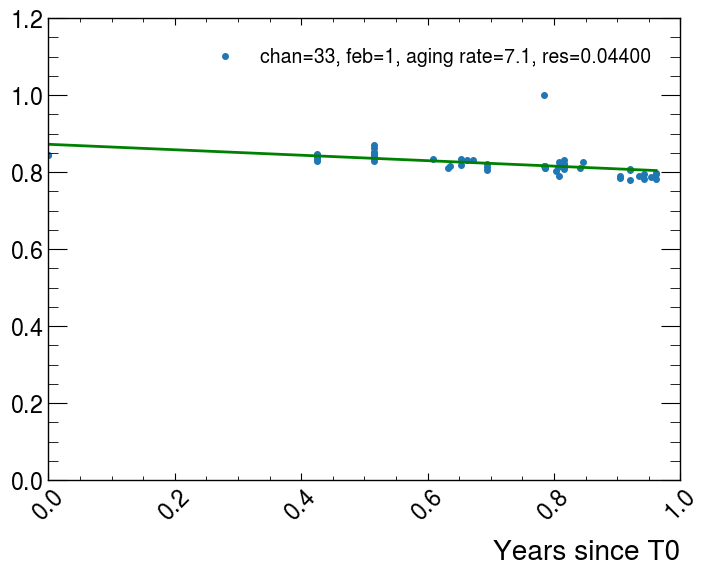

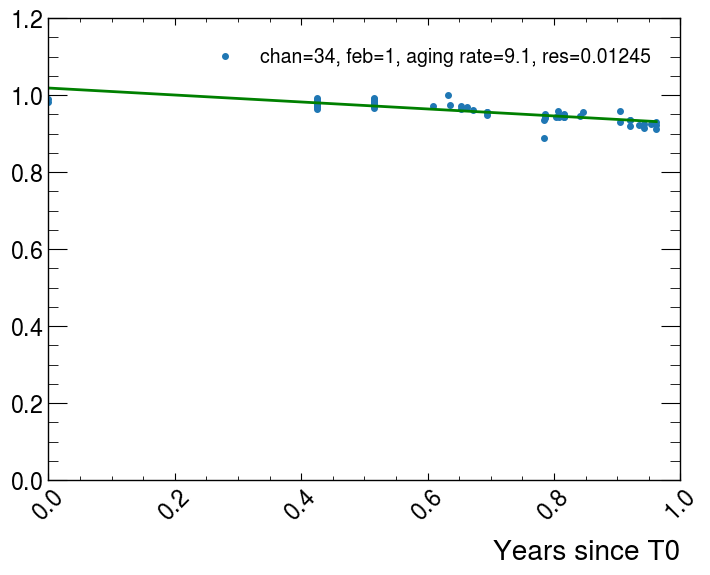

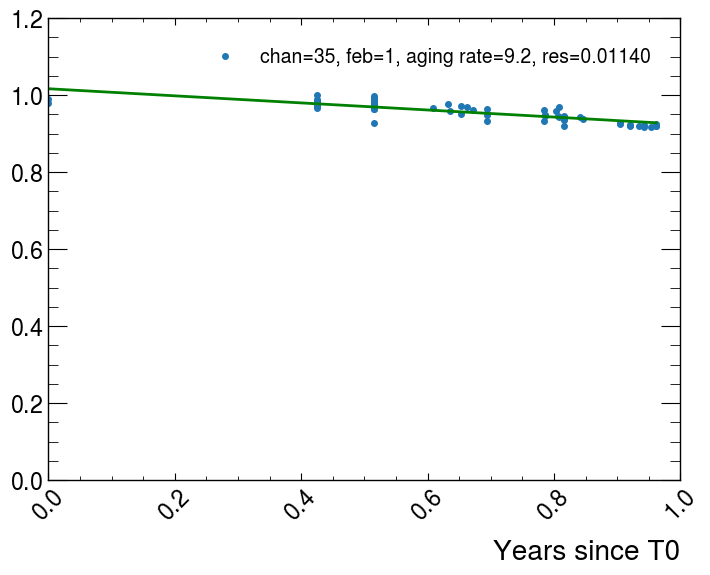

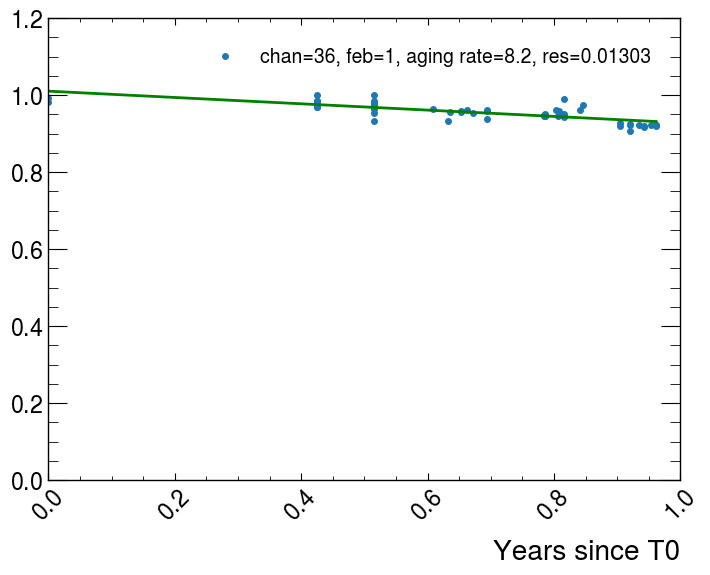

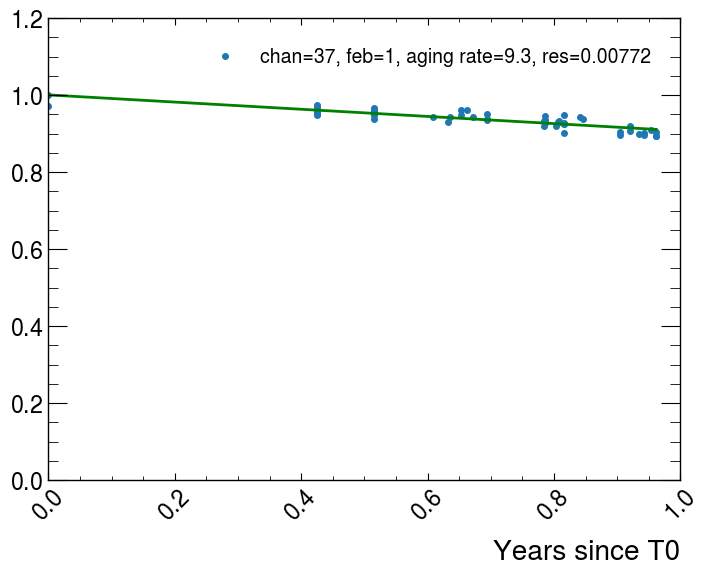

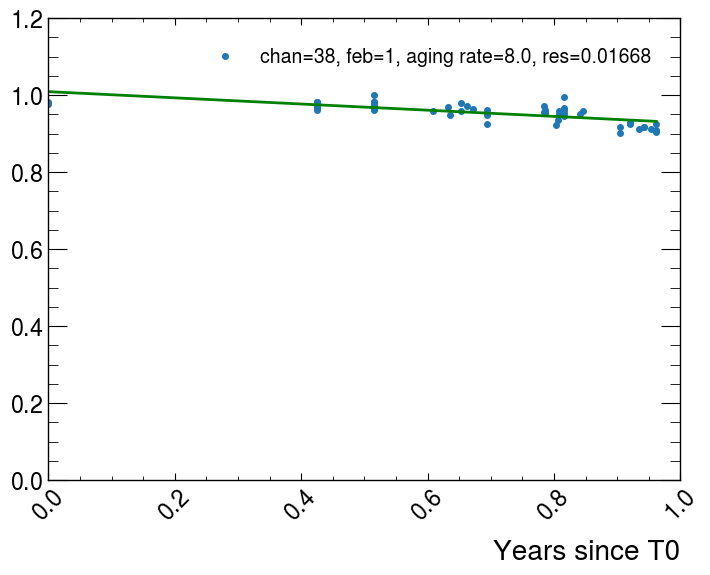

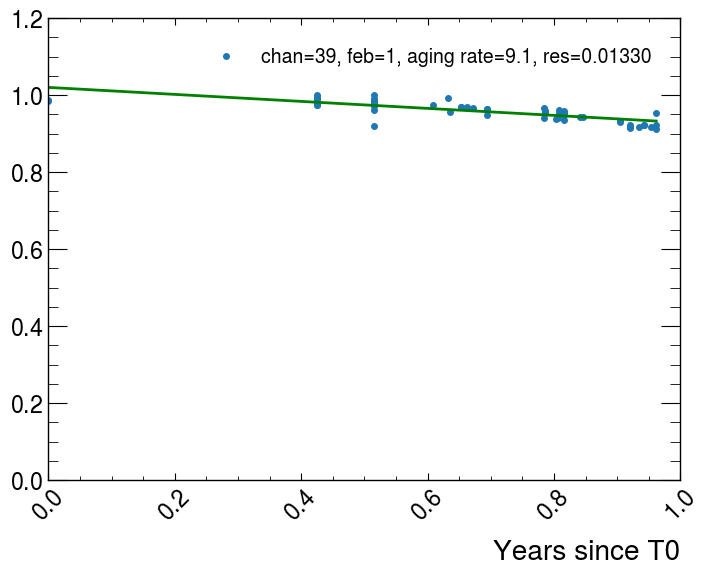

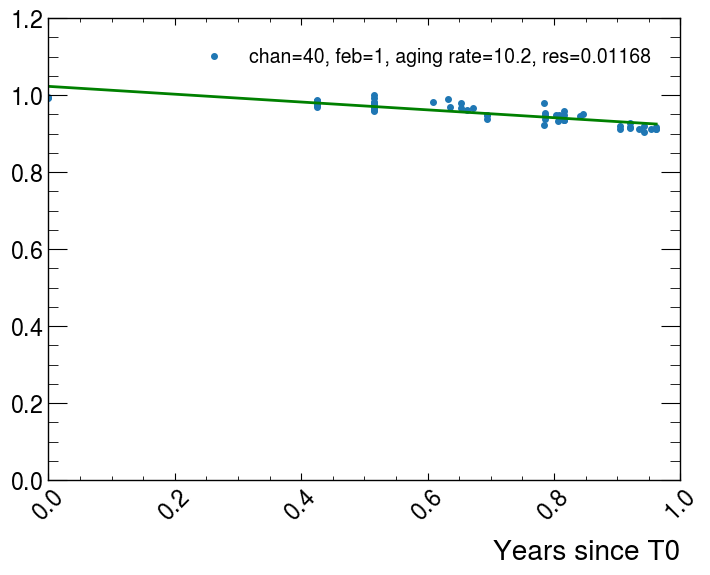

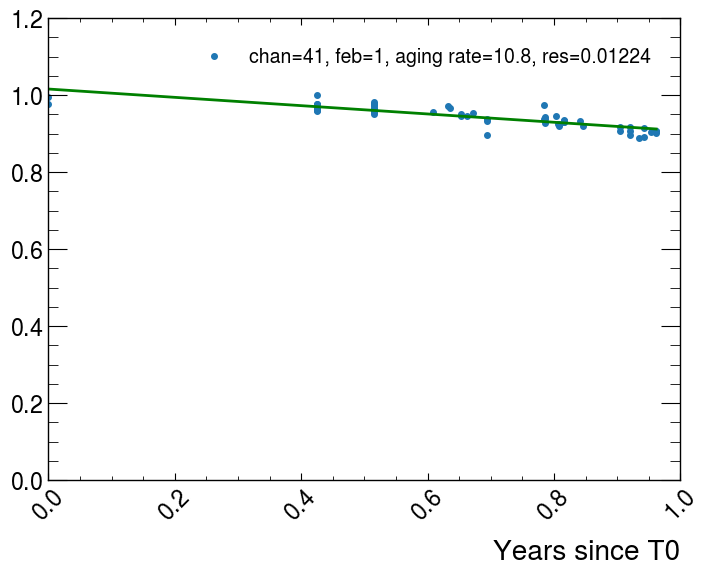

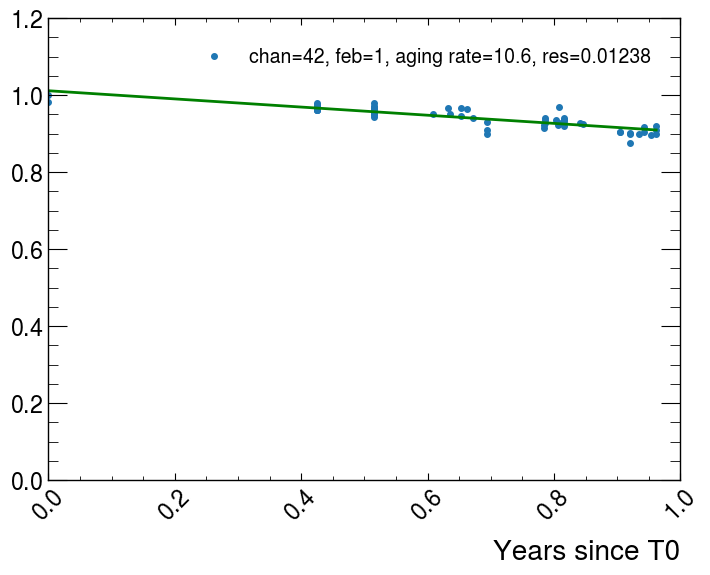

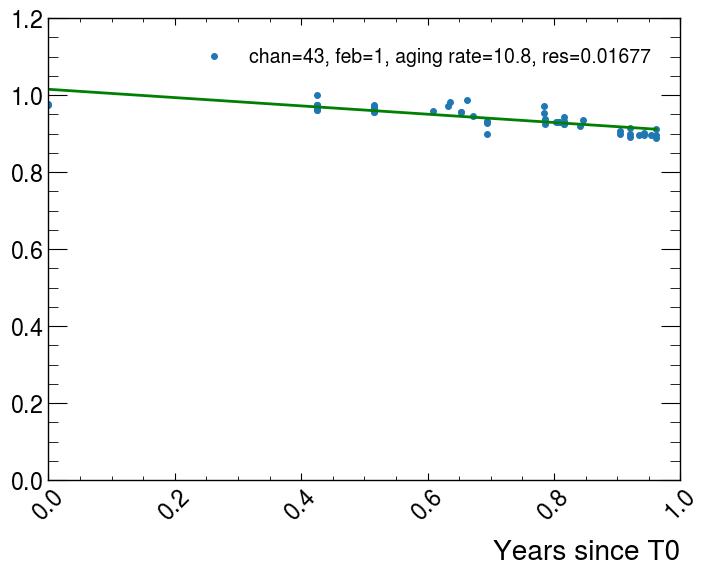

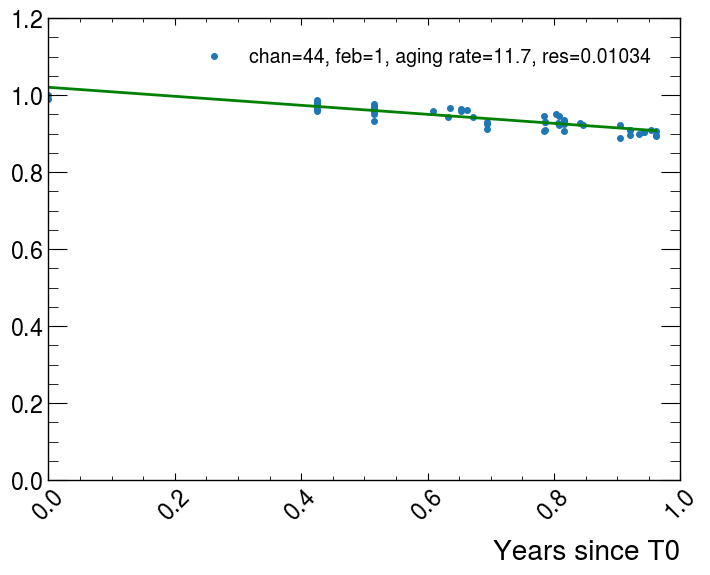

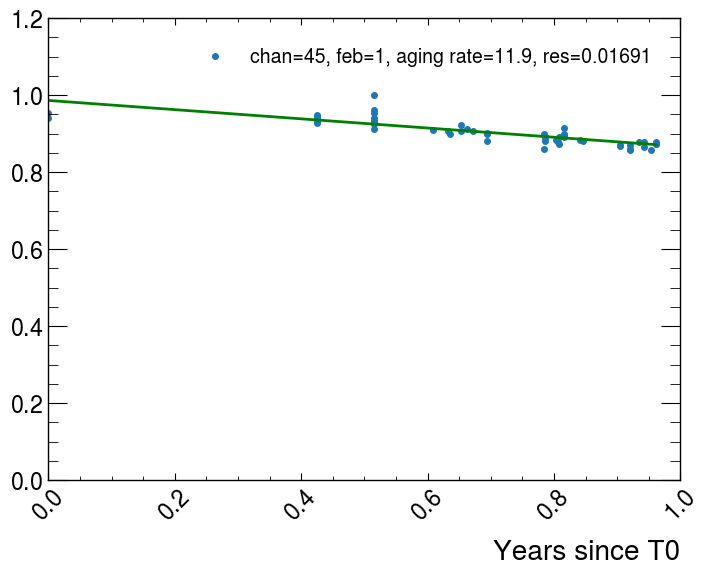

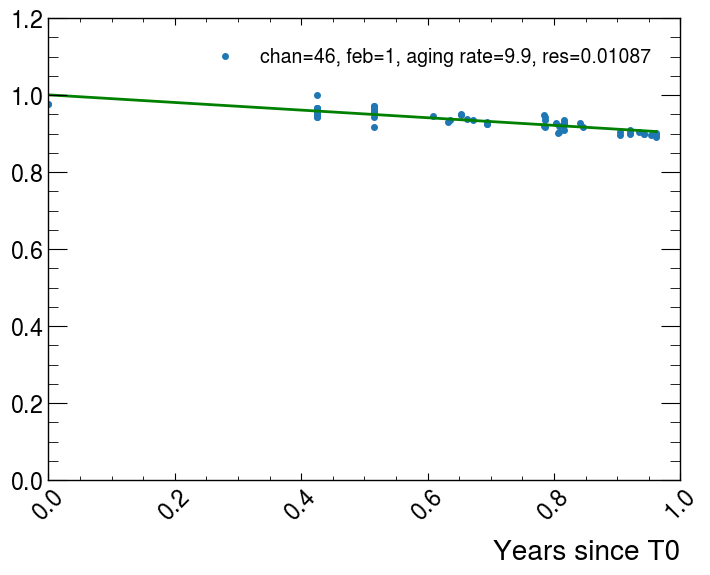

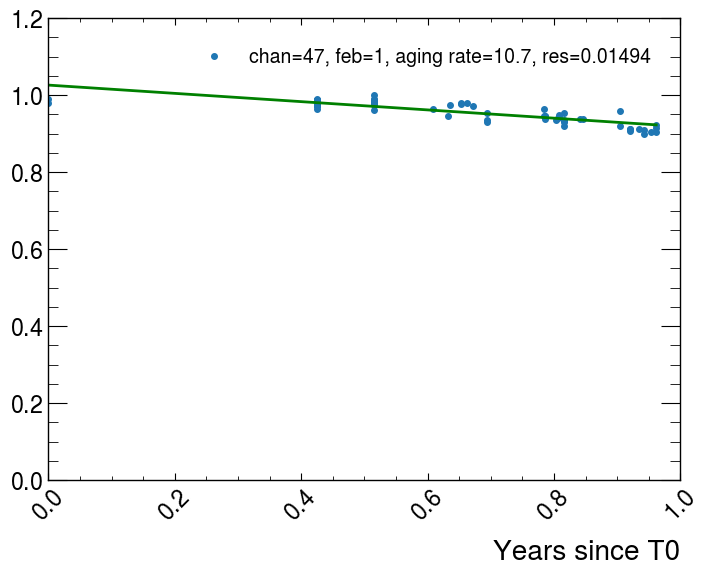

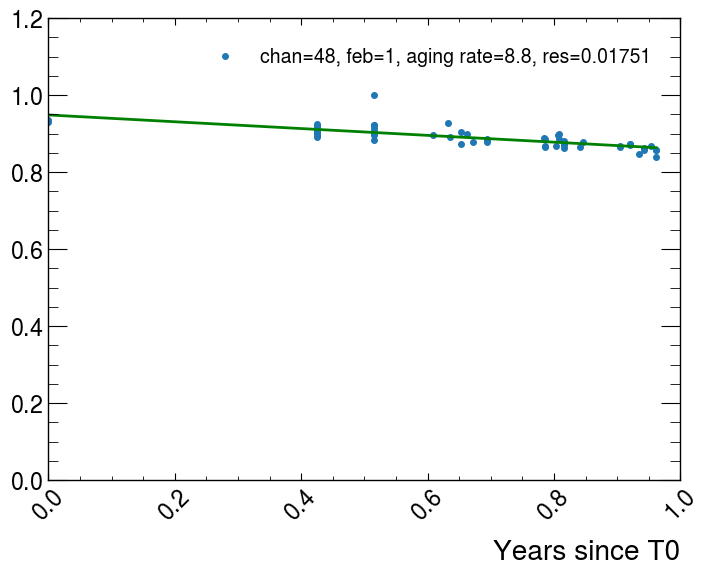

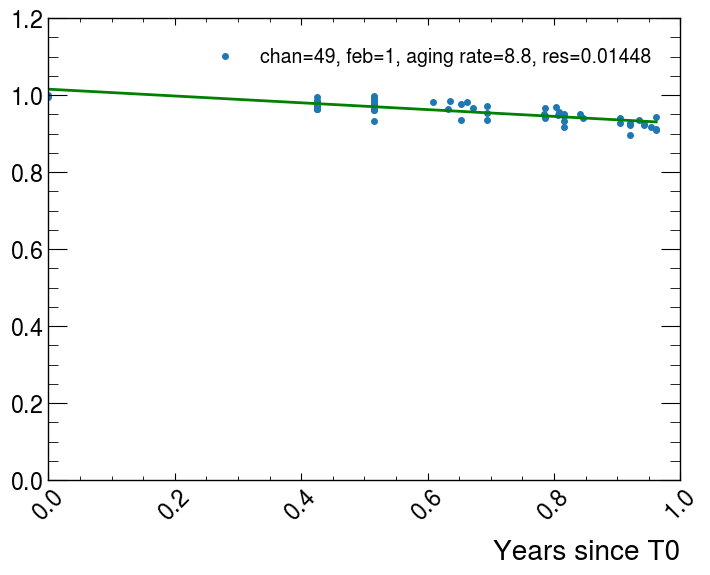

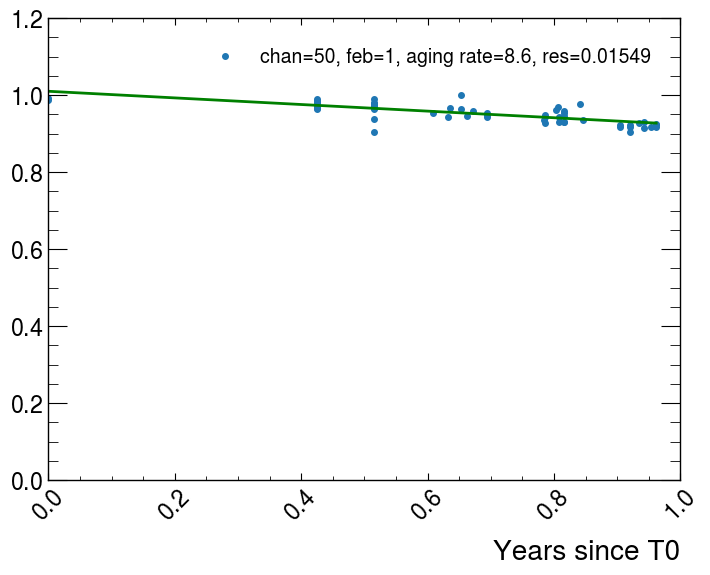

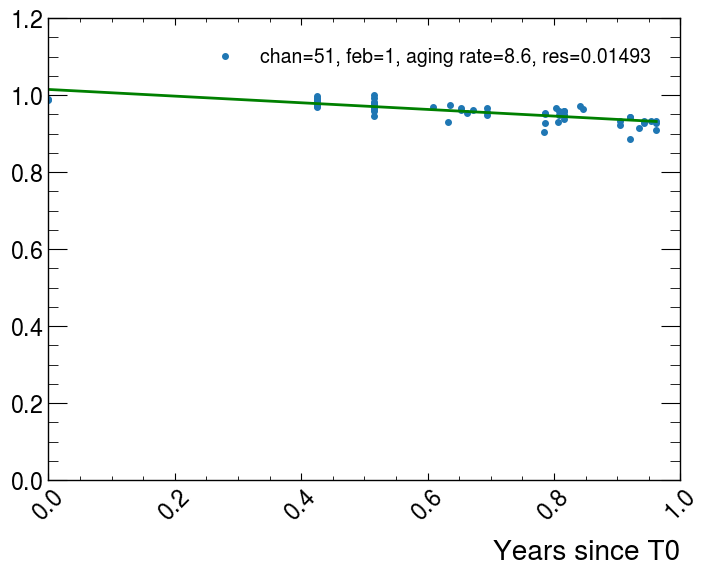

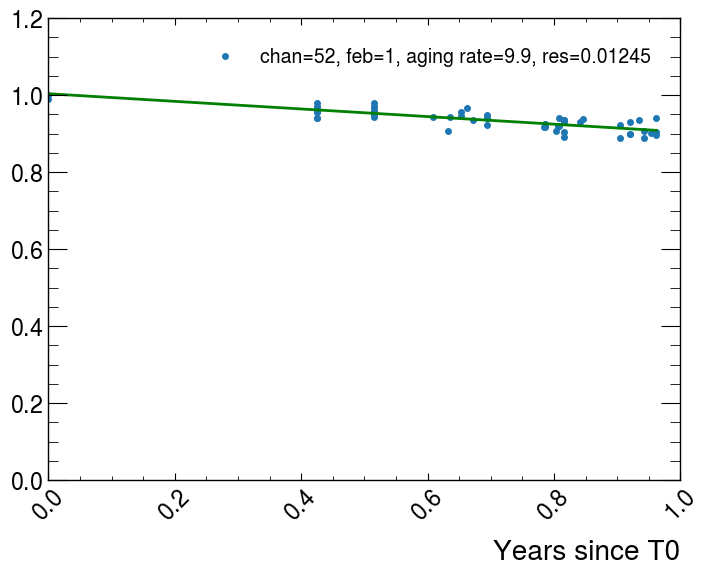

In [70]:
import numpy as np
import matplotlib.dates as mdates

aging_pct=[]

channel_range=list(range(1, 20))+list(range(33, 53))
for feb in range(0, 2):
  for chan in channel_range:
    plt.figure()
    plt.xticks(rotation=45)

    x=df.query('chan==%d and feb==%d and (DateOrd>738029 or DateOrd==737979)'%(chan,feb))['DateOrd'].to_numpy()
    x=(x-x.min())/365
    y=df.query('chan==%d and feb==%d and (DateOrd>738029 or DateOrd==737979)'%(chan,feb))['PEcorr'].to_numpy()
    y=y/y.max()

    z4, res, _, _, _ = np.polyfit(x, y, 1, full=True)

    p4 = np.poly1d(z4)
    plt.plot(x, y , '.', label='chan=%d, feb=%d, aging rate=%.1f, res=%.5f'%(chan,feb,-p4[1]*100, res))
    xx = np.linspace(x.min(), x.max(), 100)
    plt.plot(xx, p4(xx), '-g')

    if(res<0.08):
      aging_pct.append(-p4[1]*100)


    plt.legend()
    plt.ylim(0,1.2)
    plt.xlabel("Years since T0")

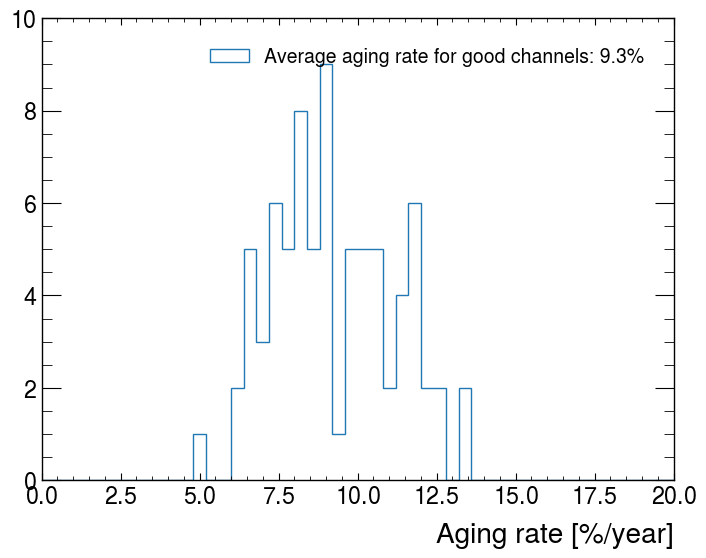

In [76]:
plt.hist(aging_pct, bins=50, range=(0,20), histtype='step', label='Average aging rate for good channels: %.1f%%'%np.mean(aging_pct));
plt.xlabel('Aging rate [%/year]');
plt.legend();